In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.constants as const

In [2]:
tr = pd.read_csv('X_train.csv')
te = pd.read_csv('X_test.csv')
target = pd.read_csv('y_train.csv')
ss = pd.read_csv('sample_submission.csv')

In [3]:
tr.head()

,row_id,series_id,measurement_number,orientation_X,orientation_Y,orientation_Z,orientation_W,angular_velocity_X,angular_velocity_Y,angular_velocity_Z,linear_acceleration_X,linear_acceleration_Y,linear_acceleration_Z
0,0_0,0,0,-0.75853,-0.63435,-0.10488,-0.10597,0.107650,0.017561,0.000767,-0.74857,2.1030,-9.7532
1,0_1,0,1,-0.75853,-0.63434,-0.10490,-0.10600,0.067851,0.029939,0.003385,0.33995,1.5064,-9.4128
2,0_2,0,2,-0.75853,-0.63435,-0.10492,-0.10597,0.007275,0.028934,-0.005978,-0.26429,1.5922,-8.7267
3,0_3,0,3,-0.75852,-0.63436,-0.10495,-0.10597,-0.013053,0.019448,-0.008974,0.42684,1.0993,-10.0960
4,0_4,0,4,-0.75852,-0.63435,-0.10495,-0.10596,0.005135,0.007652,0.005245,-0.50969,1.4689,-10.4410


It looks like linear acceleration in Z direction has gravity recorded. Lets remove gravity part.

In [4]:
tr['linear_acceleration_Z'] = tr['linear_acceleration_Z'] + const.g

In [5]:
tr.shape, te.shape

((487680, 13), (488448, 13))

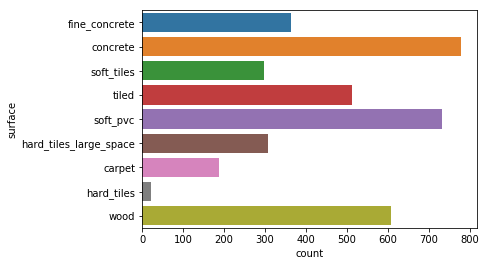

In [6]:
sns.countplot(y = 'surface', data = target)
plt.show()

In [7]:
# Function to convert quaternions to euler angles
def quaternion_to_euler(x, y, z, w):
    import math
    t0 = +2.0 * (w * x + y * z)
    t1 = +1.0 - 2.0 * (x * x + y * y)
    X = math.atan2(t0, t1)

    t2 = +2.0 * (w * y - z * x)
    t2 = +1.0 if t2 > +1.0 else t2
    t2 = -1.0 if t2 < -1.0 else t2
    Y = math.asin(t2)

    t3 = +2.0 * (w * z + x * y)
    t4 = +1.0 - 2.0 * (y * y + z * z)
    Z = math.atan2(t3, t4)

    return X, Y, Z

In [8]:
# Feature Engineering

def fe(actual):
    new = pd.DataFrame()
    
    actual['total_linear_acceleration'] = (actual['linear_acceleration_X'] ** 2 + 
                                           actual['linear_acceleration_Y'] ** 2 + 
                                           actual['linear_acceleration_Z'] ** 2) ** 0.5
    
    actual['acc_vs_X_vel'] = actual['total_linear_acceleration'] / actual['angular_velocity_X']
    actual['acc_vs_Y_vel'] = actual['total_linear_acceleration'] / actual['angular_velocity_Y']
    actual['acc_vs_Z_vel'] = actual['total_linear_acceleration'] / actual['angular_velocity_Z']
    
    # Converting to Euler Angles
    x, y, z, w = actual['orientation_X'].tolist(), actual['orientation_Y'].tolist(), actual['orientation_Z'].tolist(), actual['orientation_W'].tolist()
    nx, ny, nz = [], [], []
    for i in range(len(x)):
        xx, yy, zz = quaternion_to_euler(x[i], y[i], z[i], w[i])
        nx.append(xx)
        ny.append(yy)
        nz.append(zz)
    
    actual['euler_x'] = nx
    actual['euler_y'] = ny
    actual['euler_z'] = nz
    
    # Total Angle - nothing like this exists in reality    
    actual['angle_X_vs_acc'] = actual['euler_x'] / actual['total_linear_acceleration']
    actual['angle_Y_vs_acc'] = actual['euler_y'] / actual['total_linear_acceleration']
    actual['angle_Z_vs_acc'] = actual['euler_z'] / actual['total_linear_acceleration']
    
    #actual['angle_vs_vel'] = actual['total_angle'] / actual['total_angular_velocity']
    
    # Change of Change calc function
    def f1(x):
        return np.mean(np.diff(np.abs(np.diff(x))))
    
    #  Change calc function
    def f2(x):
        return np.mean(np.abs(np.diff(x)))
    
    # Mean, Min, Max, Std and Max/Min Calculations.
    for col in actual.columns:
        if col in ['row_id', 'series_id', 'measurement_number']:
            continue
        new[col + '_mean'] = actual.groupby(['series_id'])[col].mean()
        new[col + '_min'] = actual.groupby(['series_id'])[col].min()
        new[col + '_max'] = actual.groupby(['series_id'])[col].max()
        new[col + '_std'] = actual.groupby(['series_id'])[col].std()
        new[col + '_max_to_min'] = new[col + '_max'] / new[col + '_min']
        
        # Change. 1st order.
        new[col + '_mean_abs_change'] = actual.groupby('series_id')[col].apply(f2)
        
        # Change of Change. 2nd order.
        new[col + '_mean_change_of_abs_change'] = actual.groupby('series_id')[col].apply(f1)
        
        # Abslute max and min
        new[col + '_abs_max'] = actual.groupby('series_id')[col].apply(lambda x: np.max(np.abs(x)))
        new[col + '_abs_min'] = actual.groupby('series_id')[col].apply(lambda x: np.min(np.abs(x)))

    return new

In [9]:
tr = fe(tr)
te = fe(te)
tr.head()

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/numpy/lib/function_base.py:1946: RuntimeWarning: invalid value encountered in subtract
  a = op(a[slice1], a[slice2])


,orientation_X_mean,orientation_X_min,orientation_X_max,orientation_X_std,orientation_X_max_to_min,orientation_X_mean_abs_change,orientation_X_mean_change_of_abs_change,orientation_X_abs_max,orientation_X_abs_min,orientation_Y_mean,...,angle_Y_vs_acc_abs_min,angle_Z_vs_acc_mean,angle_Z_vs_acc_min,angle_Z_vs_acc_max,angle_Z_vs_acc_std,angle_Z_vs_acc_max_to_min,angle_Z_vs_acc_mean_abs_change,angle_Z_vs_acc_mean_change_of_abs_change,angle_Z_vs_acc_abs_max,angle_Z_vs_acc_abs_min
series_id,,,,,,,,,,,,,,,,,,,,,
0,-0.758666,-0.75953,-0.75822,0.000363,0.998275,0.000015,2.380952e-07,0.75953,0.75822,-0.634008,...,0.004478,0.509088,0.244044,1.744048,0.299159,7.146451,0.141630,0.001655,1.744048,0.244044
1,-0.958606,-0.95896,-0.95837,0.000151,0.999385,0.000023,-4.761905e-07,0.95896,0.95837,0.241867,...,0.001302,-0.178868,-1.290653,-0.053047,0.156391,0.041101,0.074352,0.000054,1.290653,0.053047
2,-0.512057,-0.51434,-0.50944,0.001377,0.990473,0.000041,0.000000e+00,0.51434,0.50944,-0.846171,...,0.001756,0.896104,0.300257,4.085138,0.766638,13.605488,0.346986,0.000037,4.085138,0.300257
3,-0.939169,-0.93968,-0.93884,0.000227,0.999106,0.000026,-6.349206e-07,0.93968,0.93884,0.310140,...,0.001170,-0.150785,-0.686786,-0.049370,0.101383,0.071885,0.062395,-0.000847,0.686786,0.049370
4,-0.891301,-0.89689,-0.88673,0.002955,0.988672,0.000080,7.936508e-08,0.89689,0.88673,0.428144,...,0.001869,-0.336040,-1.129679,-0.168267,0.181696,0.148951,0.053678,0.000040,1.129679,0.168267


In [10]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
target['surface'] = le.fit_transform(target['surface'])

In [12]:
tr.fillna(0, inplace = True)
te.fillna(0, inplace = True)
tr.replace(-np.inf, 0, inplace = True)
tr.replace(np.inf, 0, inplace = True)
te.replace(-np.inf, 0, inplace = True)
te.replace(np.inf, 0, inplace = True)

In [13]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import KFold, StratifiedKFold
folds = StratifiedKFold(n_splits=5, shuffle=True, random_state=546789)
sub_preds_rf = np.zeros((te.shape[0], 9))
oof_preds_rf = np.zeros((tr.shape[0]))
score = 0
for i, (train_index, test_index) in enumerate(folds.split(tr, target['surface'])):
    print('-'*20, i, '-'*20)
    
    clf =  RandomForestClassifier(n_estimators = 200, n_jobs = -1)
    clf.fit(tr.iloc[train_index], target['surface'][train_index])
    oof_preds_rf[test_index] = clf.predict(tr.iloc[test_index])
    sub_preds_rf += clf.predict_proba(te) / folds.n_splits
    score += clf.score(tr.iloc[test_index], target['surface'][test_index])
    print('score ', clf.score(tr.iloc[test_index], target['surface'][test_index]))
    importances = clf.feature_importances_
    indices = np.argsort(importances)
    features = tr.columns

    hm = 30
    plt.figure(figsize=(7, 10))
    plt.title('Feature Importances')
    plt.barh(range(len(indices[:hm])), importances[indices][:hm], color='b', align='center')
    plt.yticks(range(len(indices[:hm])), [features[i] for i in indices])
    plt.xlabel('Relative Importance')
    plt.show()

print('Avg Accuracy', score / folds.n_splits)

-------------------- 0 --------------------


ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

In [96]:
# https://www.kaggle.com/artgor/where-do-the-robots-drive
import itertools

def plot_confusion_matrix(truth, pred, classes, normalize=False, title=''):
    cm = confusion_matrix(truth, pred)
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(10, 10))
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title('Confusion matrix', size=15)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.grid(False)
    plt.tight_layout()

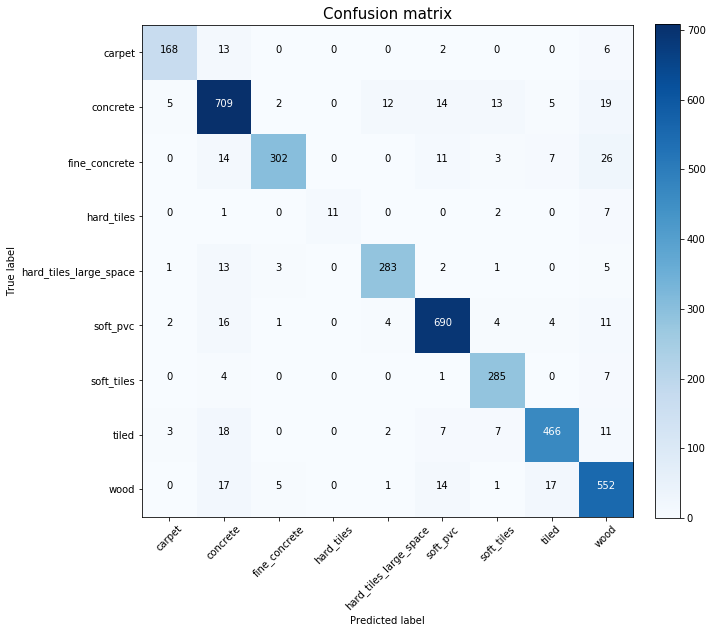

In [106]:
from sklearn.metrics import accuracy_score, confusion_matrix
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_)

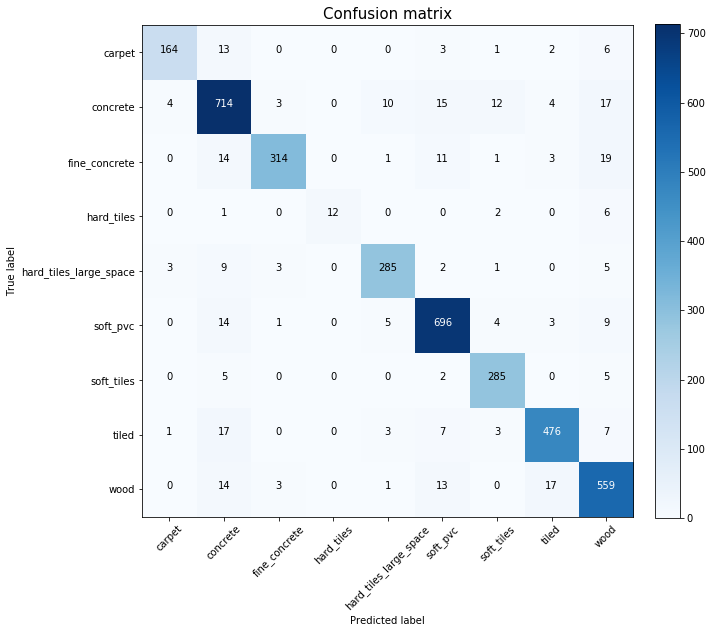

In [97]:
# Avg Accuracy 0.9199534869240658
from sklearn.metrics import accuracy_score, confusion_matrix
plot_confusion_matrix(target['surface'], oof_preds_rf, le.classes_)

In [98]:
ss['surface'] = le.inverse_transform(sub_preds_rf.argmax(axis=1))
ss.to_csv('rf.csv', index=False)
ss.head(10)

/home/nbuser/anaconda3_501/lib/python3.6/site-packages/sklearn/preprocessing/label.py:151: DeprecationWarning: The truth value of an empty array is ambiguous. Returning False, but in future this will result in an error. Use `array.size > 0` to check that an array is not empty.
  if diff:


,series_id,surface
0,0,hard_tiles_large_space
1,1,concrete
2,2,tiled
3,3,wood
4,4,soft_tiles
5,5,concrete
6,6,concrete
7,7,concrete
8,8,wood
9,9,wood
